# (0.1) Train multiple-imputation (MI) models
One option to resolve missingness for AFA is to use Multiple Imputation. 
This notebook trains MI models and saves the multiple imputed datasets. 

In [1]:
%load_ext autoreload
%autoreload 2

## Define paths

In [2]:
from afa.configurations.utils_ts import specify_default_paths_ts
# which dataset to work on 
dataset_name   = "synthetic_2"

# name for of missingness scenario 
miss_scenario  = 'MCAR_1'

# automatically specify some path locations (change paths manually if needed) 
paths = specify_default_paths_ts(dataset_name = dataset_name , miss_scenario = miss_scenario) 

# name for ps_model 
mi_model_name  = 'mi_simple'
mi_model_name  = 'mi_simple_gp'

# new (where to save the model) 
mi_model_dir = paths['data_dir']  + 'mi_models' + '/' + mi_model_name + '/'


### Define model specifications

In [6]:


# Config for dataset preparation (torch.DataSet class)
dataset_params = {
    'missingness_value': 'nan',   # int, float or 'nan'
    'missingness_rate': 0.8,
}

# Config for dataloader (torch.DataLoader class)
dataloader_params = {
    'batch_size': 100, 
    'shuffle': False, 
    # 'prefetch_factor': 1, # increase for speed up
    # 'num_workers': 0,     # set higher for faster throughput
    'drop_last': True
}

# Config for trainer (pytorch_lightning.Trainer class)
trainer_params = {
    'max_epochs': 1,    # number of epochs to train
    'auto_lr_find': False,
    'fast_dev_run': False,
    'accelerator': 'auto',
    'devices': 1,
    'profiler': None,  # 'simple', 'advanced', None
    'num_sanity_val_steps': 0,
    'patience': 30,
    'wandb_logger': False,
    'wandb_project_name': 'GPImputer Synthetic 2'
}

# Config for gp_model (GPImputer class)
gp_params = {
    'model_type': 'gaussian_process',
    'dataset_params' : dataset_params,
    'dataloader_params' : dataloader_params,
    'trainer_params' : trainer_params,
    'num_tasks': 5,  # number of tasks == number of features
    'num_kernels': 5,
    'sample_tp': 0.9,
    'data_mode': 'no_simulation',   # 'no_simulation' or 'simulation', with simulation a ground truth is expected to passed as well, ground truth = values for data that is missing in train dataloader
    'wandb_logger': False,
    # 'ckpt_path': 'best_model-v_recon_loss_target=1.10-epoch=142.ckpt',  # path to checkpoint of trained model, full path or relative to model directory    
}
    
# Config for mi_model from AFA module (MultipleImputationModel_ts class)
mi_model_params = {
    'name' : mi_model_name, 
    'directory' : mi_model_dir,
    'base_model_params' : gp_params
}

print('Done!')

Done!


## Load dataset with missingness 
At first, we want to load the dataset 

Includes loading: 
- superfeature mapping
- problem
- afa_problem 
- missingness_model

In [7]:
from afa.data_modelling.datasets.data_loader.data_loader_ts import DataLoader_ts

2023-04-26 15:42:37.788564: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-26 15:42:37.865496: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-26 15:42:37.865512: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-26 15:42:40.245650: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [8]:
data_loader = DataLoader_ts(data_file                  = paths['data_file'],
                            temporal_data_file         = paths['temporal_data_file'],
                            superfeature_mapping_file  = paths['superfeature_mapping_file'],
                            problem_file               = paths['problem_file'],
                            afa_problem_files          = paths['afa_problem_files'], 
                            miss_model_files           = paths['miss_model_files'], 
                            folds_file                 = paths['folds_file'] )
dataset = data_loader.load()

Padding sequences: 100%|██████████| 2000/2000 [00:00<00:00, 5166.83it/s]


In [6]:
type(dataset.get_data(fold=None, split='train')['temporal_feature'])
dataset.get_data(fold=None, split='train')['temporal_feature'].shape

(2000, 50, 4)

In [10]:
dataset.get_data(fold=None, split='train')['temporal_feature'][1,-5:,:]

array([[-1.86444337, -0.97411806, -0.49120211,  0.16736162],
       [-0.80662349,  1.32580364, -1.82973489, -0.15512382],
       [ 0.19273329,  0.06642369, -1.3086933 , -1.54356751],
       [ 0.01148566, -2.55265379,         nan,         nan],
       [ 1.35719251, -0.57439182,  0.12035853,  0.64955872]])

## Define MI model

In [9]:
from afa.data_modelling.missingness.multiple_imputation.multiple_imputation_model_ts import MultipleImputationModel_ts

mi_model = MultipleImputationModel_ts(  
                name                         = mi_model_params['name'], 
                m_graph                      = dataset.miss_model.m_graph, 
                superfeature_mapping         = dataset.superfeature_mapping,
                target_superfeature_names    = dataset.afa_problem.target_superfeature_names,
                model_params                 = mi_model_params,
                directory                    = mi_model_params['directory']) 

Global seed set to 42
/home2/joshua.wendland/Documents/afa_ts/afa_env/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:55: LightningDeprecationWarning: Setting `Trainer(resume_from_checkpoint=)` is deprecated in v1.5 and will be removed in v2.0. Please pass `Trainer.fit(ckpt_path=)` directly instead.
  rank_zero_deprecation(


{'batch_size': 128,
 'data_missingness': 0.6,
 'data_mode': 'no_simulation',
 'dataloader_params': {'batch_size': 100, 'drop_last': True, 'shuffle': False},
 'dataset_name': 'toydataset_50000',
 'dataset_params': {'missingness_rate': 0.8, 'missingness_value': 'nan'},
 'directory': '../../../data/ts/synthetic_2/MCAR_1/mi_models/mi_simple_gp/',
 'lr': 0.01,
 'model_type': 'gaussian_process',
 'model_weights_save_path': './model_weights',
 'num_epochs': 10,
 'num_kernels': 5,
 'num_tasks': 5,
 'rank': 4,
 'sample_tp': 0.9,
 'sample_tp_interval': [0.3, 0.8],
 'task_names': ['Noise', 'Trend', 'Seasonality', 'Trend + Seasonality'],
 'trainer_params': {'accelerator': 'auto',
                    'auto_lr_find': False,
                    'devices': 1,
                    'fast_dev_run': False,
                    'max_epochs': 1,
                    'num_sanity_val_steps': 0,
                    'patience': 30,
                    'profiler': None,
                    'wandb_logger': False,
  

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Loaded model from checkpoint: ../../../data/ts/synthetic_2/MCAR_1/mi_models/mi_simple_gp/model_weights/best_model-v_recon_loss_target=1.10-epoch=145.ckpt


In [21]:
mi_model.base_model.load_trainer_from_ckpt

'no'

## Train MI model 

In [ ]:
mi_model.base_model.trainer.fit_loop.max_epochs
# print(mi_model.base_model.device)
# print(mi_model.base_model.get_checkpoint_path('best_model-v_recon_loss_target=1.54-epoch=40.ckpt'))

100

In [15]:
print('FSef')

FSef


In [17]:
mi_model.fit(dataset, fold=None, train_split='train', valid_split='val', fit_again=False)

Base Model gaussian_process already trained. Not fitting again... 


Batch sampling:   0%|          | 0/2000 [00:00<?, ?it/s]

input_task_t_target: torch.Size([250, 2]), torch.float32
input_task_t_context: torch.Size([189, 2]), torch.float32
full_x_context: torch.Size([189]), torch.float32
input_task_t_target: torch.Size([250, 2]), torch.float32
input_task_t_context: torch.Size([192, 2]), torch.float32
full_x_context: torch.Size([192]), torch.float32
input_task_t_target: torch.Size([250, 2]), torch.float32
input_task_t_context: torch.Size([194, 2]), torch.float32
full_x_context: torch.Size([194]), torch.float32
input_task_t_target: torch.Size([250, 2]), torch.float32
input_task_t_context: torch.Size([188, 2]), torch.float32
full_x_context: torch.Size([188]), torch.float32
input_task_t_target: torch.Size([250, 2]), torch.float32
input_task_t_context: torch.Size([196, 2]), torch.float32
full_x_context: torch.Size([196]), torch.float32
input_task_t_target: torch.Size([250, 2]), torch.float32
input_task_t_context: torch.Size([191, 2]), torch.float32
full_x_context: torch.Size([191]), torch.float32
input_task_t_tar

--- 
# Evaluating MI model

In [12]:
import afa.data_modelling.models.temporal_models.mi_models.gp_model as GPFile
from afa.data_modelling.models.temporal_models.mi_models.gp_model import MGPImputer
from afa.data_modelling.models.temporal_models.mi_models.missingness_dataloader import MissingnessDataset
from torch.utils.data import DataLoader
import numpy as np

fold = None; split = 'valid'
data_valid       = dataset.get_data(fold = fold, split = split)
# get concatenated features and label 
Xy,t = mi_model._preprocess(data_valid) 
Xyt = np.concatenate([Xy, t], axis=-1)

GaussianProcessImputer = mi_model.base_model
gp_model = GaussianProcessImputer.gpmodel
assert(isinstance(gp_model, MGPImputer))

# prepare data in batches
dataloader = DataLoader(MissingnessDataset(Xyt, missingness_value='nan', missingness_rate=0.0), batch_size=10, shuffle=False)

# Visualize performance of MI model by sampling from it and then plotting it

In [42]:
import afa.data_modelling.models.temporal_models.mi_models.gp_model as GPFile
from afa.data_modelling.models.temporal_models.mi_models.gp_model import MGPImputer
from afa.data_modelling.models.temporal_models.mi_models.missingness_dataloader import MissingnessDataset
from torch.utils.data import DataLoader
import numpy as np

data = dataset.get_data(fold = None, split = 'train')
Xy_train, t_train = mi_model._preprocess(data)
Xyt_train = np.concatenate([Xy_train, t_train], axis=-1)
index = slice(10)
Xy = Xy_train[index]
t = t_train[index]
Xyt = Xyt_train[index]

GaussianProcessImputer = mi_model.base_model
gp_model = GaussianProcessImputer.gpmodel
assert(isinstance(gp_model, MGPImputer))

# prepare data in batches
dataloader = DataLoader(MissingnessDataset(Xyt, missingness_value='nan', missingness_rate=0.0), batch_size=10, shuffle=False)
batch = next(iter(dataloader))
batch = batch.to(gp_model.device)
masks, values, t = GPFile.mask_collate(batch)

# impute a batch
pred_mean_batch, quantile_low_batch, quantile_high_batch, sampled_seqs_batch, mask_dict_batch = gp_model.impute_and_sample_in_batch(masks, values, t, sample_size=100)
outcomes = [pred_mean_batch, quantile_low_batch, quantile_high_batch, sampled_seqs_batch]
names = ['pred_mean_batch', 'quantile_low_batch', 'quantile_high_batch', 'sampled_seqs_batch']
# print([name + ': ' + str(outcome.shape) for name, outcome in zip(names, outcomes)])
print([name + ': ' + str(type(outcome)) for name, outcome in zip(names, outcomes)])

# plot a sample from a batch
sample_index = 2
X_miss = values[sample_index]
t_context = t
t_target = t
pred_mean = pred_mean_batch[sample_index]
quantile_low = quantile_low_batch[0][sample_index]
quantile_high = quantile_high_batch[0][sample_index]
mask_dict = {key:mask[sample_index] for key, mask in mask_dict_batch.items()}
observed_pred = None
full_observed = Xy_train[sample_index]

["pred_mean_batch: <class 'torch.Tensor'>", "quantile_low_batch: <class 'list'>", "quantile_high_batch: <class 'list'>", "sampled_seqs_batch: <class 'torch.Tensor'>"]


In [78]:
import torch
t_target = torch.linspace(0, 49, 100)

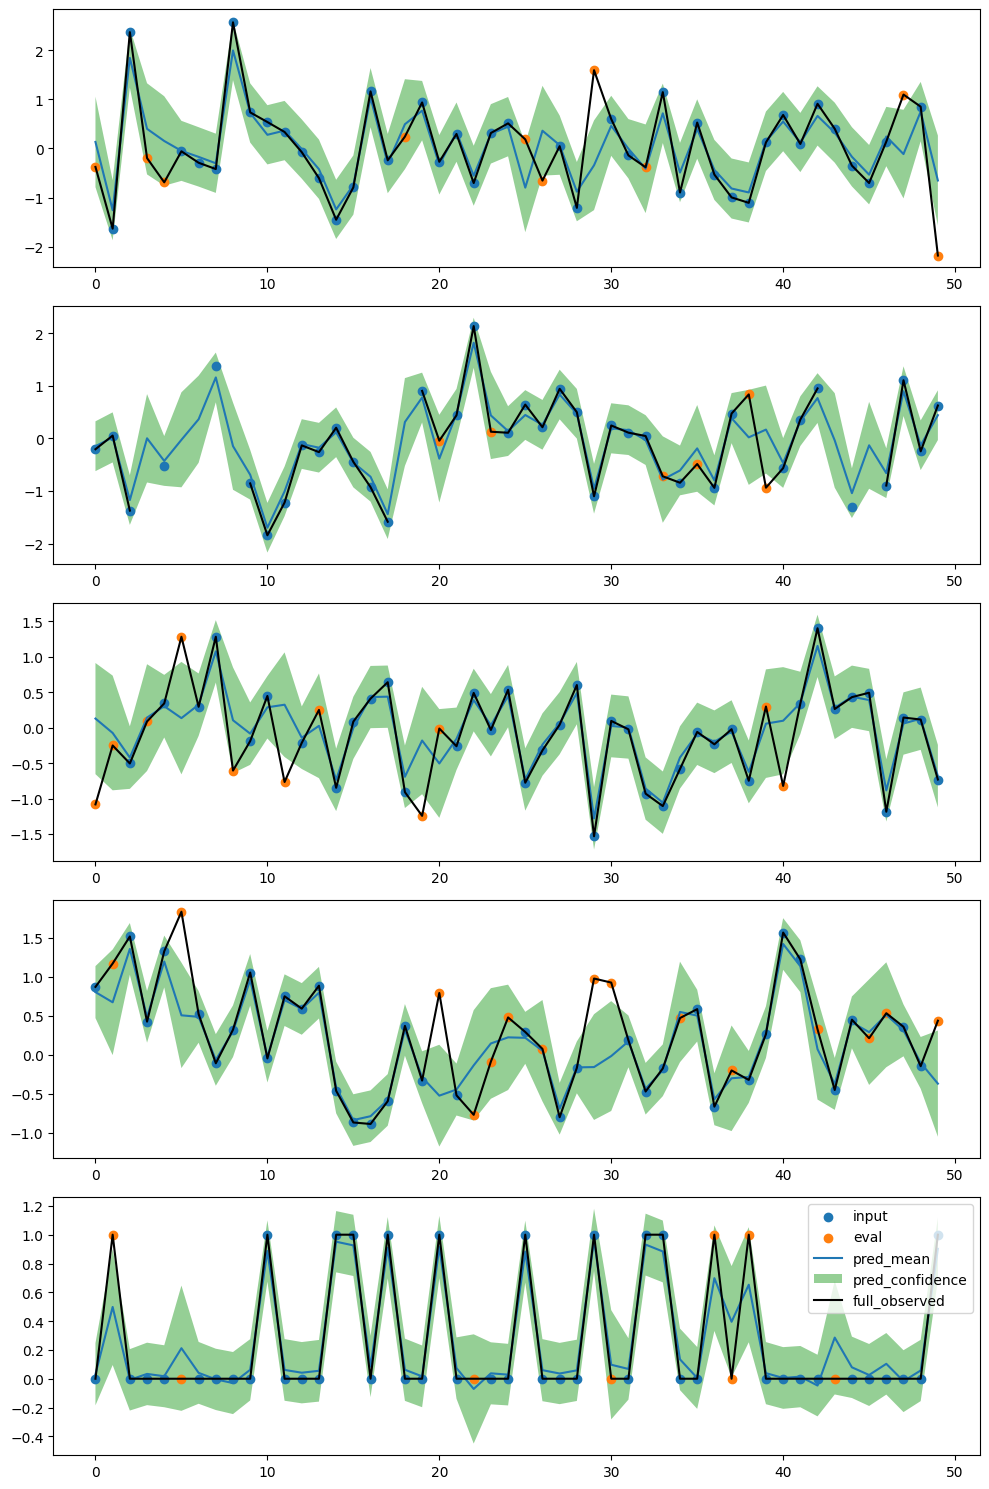

In [10]:
gp_model.plot_sample(X_miss, t_context, t_target, pred_mean, quantile_low, quantile_high, mask_dict, observed_pred=None, full_observed=full_observed)

# Visualize the raw data

(50, 5)

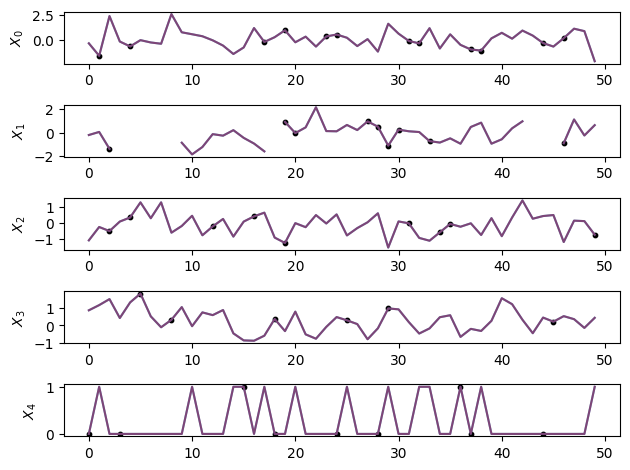

In [57]:
import matplotlib.pyplot as plt
# Xy_train, t_train

Xy = Xy_train[sample_index]
t = t_train[sample_index]
input = values[sample_index]

fig = plt.figure()
num_features = Xy.shape[-1]
for i in range(num_features):
    fig.add_subplot(num_features, 1, i+1)
    plt.plot(t, Xy[:,i], label=f'feature {i}')
    plt.plot(t, input[:,i], c='crimson', label=f'input {i}', alpha=0.5)
    # t_extra = t[mask_dict['input'][:,i] == 1]
    # plt.scatter(t_extra, X_miss[:,i][mask_dict['input'][:,i] == 1], s=10, c='black', label=f'missing {i}')
    mask_input = (mask_dict['input'] == 1)
    plt.scatter(t[mask_input[:,i]], X_miss[:,i][mask_input[:,i]], s=10, c='black', label=f'missing {i}')
    # plt.scatter(t, X_miss[:,i], s=10, c='black', label=f'missing {i}')
    plt.ylabel(f'$X_{i}$')
    
plt.tight_layout()
Xy.shape

In [63]:
mask_input = mask_dict['input']
mask_eval = mask_dict['eval']
mask_gt = mask_dict['gt']

print((mask_input + mask_eval + mask_gt == 1).all())
print((mask_input + mask_eval + mask_gt).mean())
print((mask_input * mask_eval * mask_gt == 0).all())

tensor(False)
tensor(1.9440, dtype=torch.float64)
tensor(True)


## Create multiple imputed dataset

In [14]:
from afa.data_modelling.missingness.multiple_imputation.multiple_imputed_dataset_ts import MultipleImputedDataset_ts

In [15]:
# TODO check the code for predict, when n_samples > 1, what does the code expect?
mi_results = mi_model.predict(dataset, n_samples = 5)

# create an mi_dataset out of the generated imputations
mi_dataset = MultipleImputedDataset_ts(  dataset = dataset, model = mi_model, results = mi_results) 

Commented out


torch.Size([10000, 50, 3])


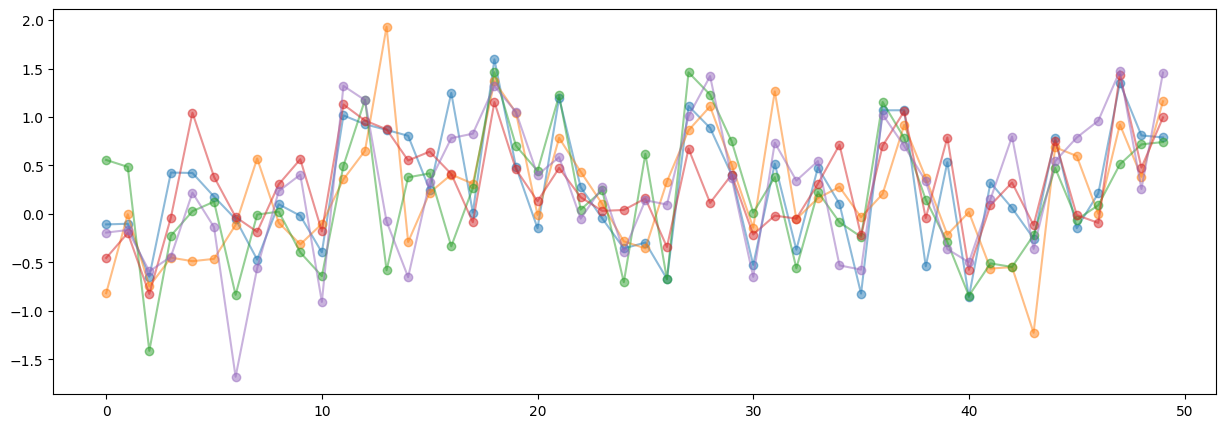

In [16]:
# make sure, that the imputed dataset is of the correct shape
from matplotlib import pyplot as plt
print( mi_results['target_feature'].shape)
samples = mi_results['target_feature'][:5]  # shape: num_samples, num_timesteps, num_features
feature_index = 2



fig = plt.figure(figsize=(15,5))
for i in range(samples.shape[0]):
    plt.plot( samples[i,:,feature_index], label=f'sample {i}', marker='o', alpha=0.5)
plt.show()

## Evaluate imputation model on ground truth dataset

In [81]:
# TO DO

## Save MI dataset

In [17]:
mi_dataset.save( model_dir = mi_model_dir) 

---
---
# Evaluation of MI Model

+ Percent Bias / Raw Bias
+ Coverage Rate
+ Average Width


### Data preparation
Preparing data so it can be used when calculating the metrics below

In [13]:
import afa.data_modelling.models.temporal_models.mi_models.gp_model as GPFile
from afa.data_modelling.models.temporal_models.mi_models.gp_model import MGPImputer
from afa.data_modelling.models.temporal_models.mi_models.missingness_dataloader import MissingnessDataset
from torch.utils.data import DataLoader
import scipy.stats
from tqdm.notebook import tqdm
from copy import deepcopy
import numpy as np
from pprint import pprint

# Beware: This model needs to be loaded from above first, then it can be used here
GaussianProcessImputer = mi_model.base_model
gp_model = GaussianProcessImputer.gpmodel
assert(isinstance(gp_model, MGPImputer))
batch_size = 500
# get MCAR dataloader
data = dataset.get_data(fold = None, split = 'test')
Xy, t = mi_model._preprocess(data)
Xyt = np.concatenate([Xy, t], axis=-1)
dataloader = DataLoader(MissingnessDataset(Xyt, missingness_value='nan', missingness_rate=0.0), batch_size=batch_size, shuffle=False)
# get gt Datalaoder (data without any missingness at all)
paths_gt = specify_default_paths_ts(dataset_name = "synthetic_2" , miss_scenario = 'fully_observed') # this dataloading has been done above for MCAR alraedy
data_loader_gt = DataLoader_ts(
                    data_file                  = '/home2/joshua.wendland/Documents/data/ts/synthetic_2/fully_observed/synthetic_2_static.csv.gz',
                    temporal_data_file         = '/home2/joshua.wendland/Documents/data/ts/synthetic_2/fully_observed/synthetic_2_ts_eav.csv.gz',
                    superfeature_mapping_file  = paths_gt['superfeature_mapping_file'],
                    problem_file               = paths_gt['problem_file'],
                    afa_problem_files          = paths_gt['afa_problem_files'], 
                    miss_model_files           = None, 
                    folds_file                 = paths_gt['folds_file'] )
dataset_gt = data_loader_gt.load()
data_gt = dataset_gt.get_data(fold = None, split = 'test')
Xy_gt, t_gt = mi_model._preprocess(data_gt)
Xyt_gt = np.concatenate([Xy_gt, t_gt], axis=-1)
dataloader_gt = DataLoader(MissingnessDataset(Xyt_gt, missingness_value='nan', missingness_rate=0.0), batch_size=batch_size, shuffle=False)

save_dir = '/home2/joshua.wendland/Documents/sepsis/notebooks/synthetic_2'

Padding sequences: 100%|██████████| 2000/2000 [00:00<00:00, 5207.90it/s]


# MAE, MSE

Just to double check, let us calculate the MAE and MSE again.



## Percent Bias

In [14]:


def calc_bias(X, Y, mask, keep_vars=True):
        """Returns raw bias and percent bias between X and Y.

        Args:
            X (any): Original values X.
            Y (any): New or predicted values of X, Y.
            mask (any): An array indicating, at which locations should be computed. (1=compute, 0=ignore).
            keep_vars (bool): Whether the average over all variables should be calculated or not. Defaults to False.

        Returns:
            any, any: raw_bias and percent_bias
        """
        # assert(type(X) == type(Y)), f'Input of X, Y is not of same type, instead {type(X)}, {type(Y)} and mask is {type(mask)}'
        X, Y, mask = np.array(X), np.array(Y), np.array(mask)
        raw_bias     = (Y - X)
        percent_bias = raw_bias / (X + (X==0))   # avoid devision by zero
        raw_bias     *= mask
        percent_bias *= mask * (X != 0)
        if keep_vars is False:
            axis = None
        else:
            axis = tuple(range(raw_bias.ndim-1))
        no_nans = ~np.isnan(percent_bias)
        percent_bias = percent_bias.sum(axis=axis, where=no_nans) / mask.sum(axis=axis, where=no_nans)
        no_nans = ~np.isnan(raw_bias)
        raw_bias     = raw_bias.sum(axis=axis) / mask.sum(axis=axis, where=no_nans)
        return raw_bias, percent_bias


---
# Coverage Ratio

In [15]:
def calc_coverage_and_width(quantiles: list, quantiles_low: "list[np.ndarray]", quantiles_high: "list[np.ndarray]", gt_masked: np.ndarray, mask: np.ndarray, axis=(0,1)):
    cov_dict, width_dict = dict(), dict()
    for q, q_low, q_high in zip(quantiles, quantiles_low, quantiles_high):
        cov = np.nanmean((q_low <= gt_masked) * (gt_masked <= q_high), where=mask, axis=axis)
        width = np.nanmean(np.abs(q_high - q_low), where=mask, axis=axis)
        cov_dict[q] = cov
        width_dict[q] = width
    return cov_dict, width_dict

def _append_cov_width_dict(old: dict, new: dict):
    """
    Updates the coverage and width dict by appending values from new batch
    
    Expected structure of dict:  
        {quantile1: quantile_boundary_batch_list,   
        ..., 
        quantileN: quantile_boundary_batch_list}  

    Parameters
    ----------
    old : dict
        _description_
    new : dict
        _description_
    """
    for quantile in new.keys():
        # iterate through all keys of new dict
        if quantile in old.keys():
            # if key is already in old dict, append the new value
            old[quantile].append(new[quantile])
        else:
            # if key is not in old dict, create a list with value for new key
            old[quantile] = [new[quantile]]
            
    return old

---
# MAE and MSE

In [16]:
def mean_absolute_error(X, Y, mask=None, axis=None):
    return np.mean(np.abs(Y - X), where=mask, axis=axis)

def mean_squared_error(X, Y, mask=None, axis=None):
    return np.mean((Y - X)**2, where=mask, axis=axis)

In [17]:
# ALL metrics in one iteration
def calculate_metrics(gp_model:MGPImputer, dataloader, gt_dataloader, num_samples=100, sample_tp=0.9, quantiles: list=None) -> 'dict[str, dict]':
    dim = 5    
    case_dict = {'input': {sample_tp: list()}, 'eval': {sample_tp: list()}, 'gt': {sample_tp: list()}}
    case_dict_quantiles = {'input': {sample_tp: dict()}, 'eval': {sample_tp: dict()}, 'gt': {sample_tp: dict()}}
    error_dict = {
        'mae': deepcopy(case_dict), 
        'mse': deepcopy(case_dict), 
        'percent_bias': deepcopy(case_dict), 
        'raw_bias': deepcopy(case_dict),
        'coverage_ratio': deepcopy(case_dict_quantiles),
        'average_width': deepcopy(case_dict_quantiles)}

    # we iterate through the batches
    for batch, batch_gt in tqdm(zip(dataloader, gt_dataloader), total=len(dataloader), desc='metrics', leave=True):
        masks, values, t = GPFile.mask_collate(batch)
        masks_gt, values_gt, t_gt = GPFile.mask_collate(batch_gt)

        # get the predictions
        pred_mean, quantiles_low, quantiles_high, pred_samples, mask_dict = gp_model.impute_and_sample_in_batch(
                                masks, 
                                values, 
                                t, 
                                sample_tp=sample_tp, 
                                sample_size=num_samples, 
                                quantiles=quantiles
        )
        gt = values_gt.numpy()
        pred_mean = pred_mean.numpy()
        quantiles_low = [q_low.numpy() for q_low in quantiles_low]
        quantiles_high = [q_high.numpy() for q_high in quantiles_high]
        
        # sanity check that all masks are correct
        mask_sub = mask_dict['input']
        mask_recon = mask_dict['eval']
        mask_gt = mask_dict['gt']
        assert(((mask_sub+mask_recon+mask_gt) == 1).all()), f'There were values above 1, when adding. {((mask_sub+mask_recon+mask_gt) == 1).sum()} / {mask_sub.numel()}'
        assert(((mask_sub*mask_recon*mask_gt)==0).all()), 'There were values != 0, when multiplying'
        assert((np.isnan(gt)).any() == False), 'There were nan values in the gt (ground truth)'
        
        # iterate over all three data cases 'subsample', 'recon', 'gt'
        for data_case in case_dict.keys():
            # get the corresponding mask
            mask = mask_dict[data_case].cpu().numpy().astype(np.bool8)
            gt_masked = gt * mask
            # calculate mae
            mae = mean_absolute_error(pred_mean, gt, mask, axis=(0,1))
            # calculate mse
            mse = mean_squared_error(pred_mean, gt, mask, axis=(0,1))
            # calculate bias
            rb, pb = calc_bias(values_gt, pred_mean, mask, keep_vars=True)
            # calculate coverage ratio and width
            # cov = np.nanmean((quantile_low <= gt_masked) * (gt_masked <= quantile_high), where=mask, axis=(0,1))
            # width = np.nanmean(np.abs(quantile_high - quantile_low), where=mask, axis=(0,1))
            covs, widths = calc_coverage_and_width(quantiles, quantiles_low, quantiles_high, gt_masked, mask, axis=(0,1))
            
            # add to the previous values
            error_dict['mae'][data_case][sample_tp].append(mae)            # will contain [...][sample_tps][error_values]
            error_dict['mse'][data_case][sample_tp].append(mse)            # will contain [...][sample_tps][error_values]
            error_dict['raw_bias'][data_case][sample_tp].append(rb)        # will contain [...][sample_tps][error_values]
            error_dict['percent_bias'][data_case][sample_tp].append(pb)    # will contain [...][sample_tps][error_values]
            new_dict = _append_cov_width_dict(error_dict['coverage_ratio'][data_case][sample_tp], covs)
            error_dict['coverage_ratio'][data_case][sample_tp] = new_dict  # will contain [...][sample_tps][quantiles][error_values]
            new_dict = _append_cov_width_dict(error_dict['average_width'][data_case][sample_tp], widths)
            error_dict['average_width'][data_case][sample_tp] = new_dict   # will contain [...][sample_tps][quantiles][error_values]
            
    
    # we want mean error per variable, so we iterate through all metrics
    for metric_name in error_dict.keys():
        # iterate through all data cases
        for data_case in error_dict[metric_name].keys():
            
            if  metric_name in ['coverage_ratio', 'average_width']:
                # these metrics have a slightly different structure (another hierarchy for quantiles)
                for quantile in error_dict[metric_name][data_case][sample_tp].keys():
                    quantiles_batch = error_dict[metric_name][data_case][sample_tp][quantile]
                    # stack all results in quantiles_batch
                    stacked = np.stack(quantiles_batch, axis=0)
                    # calculate mean over all batches
                    error_dict[metric_name][data_case][sample_tp][quantile] = np.nanmean(stacked, axis=0)

                    # quantile_list = error_dict[metric_name][data_case][sample_tp]
                    # stackeds = [np.stack(values, axis=0) for values in quantile_list]
                    # error_dict[metric_name][data_case][sample_tp] = [np.nanmean(stacked, axis=0) for stacked in stackeds]
            else:
                stacked = np.stack(error_dict[metric_name][data_case][sample_tp], axis=0)
                error_dict[metric_name][data_case][sample_tp] = np.nanmean(stacked, axis=0)
            
    return error_dict

In [18]:
def deep_update(mapping: "Dict[KeyType, Any]", *updating_mappings: "Dict[KeyType, Any]") -> "Dict[KeyType, Any]":
    """
    Used to update error_dict for different sample_tps. It does not only update the most surfacelevel dict, but it also updates the nested dicts via recursion.

    Parameters
    ----------
    mapping : Dict[KeyType, Any]
        The already existing error_dict.
    *updating_mappings: "Dict[KeyType, Any]"
        New error_dict for a different sample_tp. As many new error_dicts as arguments as you want.

    Returns
    -------
    Dict[KeyType, Any]
        The updated error_dict.
    """
    # from https://pydantic.dev/
    # URL: https://github.com/pydantic/pydantic/blob/fd2991fe6a73819b48c906e3c3274e8e47d0f761/pydantic/utils.py#L200
    updated_mapping = mapping.copy()
    for updating_mapping in updating_mappings:
        for k, v in updating_mapping.items():
            if k in updated_mapping and isinstance(updated_mapping[k], dict) and isinstance(v, dict):
                updated_mapping[k] = deep_update(updated_mapping[k], v)
            else:
                updated_mapping[k] = v
    return updated_mapping

In [19]:
sample_tps = np.arange(0.1, 1.0, 0.1)
quantiles = np.arange(0.1, 1.0, 0.1)
error_dict = {}
for sample_tp in tqdm(sample_tps, desc='sample_tps'):
    new_error_dict = calculate_metrics(gp_model, dataloader, dataloader_gt, num_samples=100, sample_tp=sample_tp, quantiles=quantiles)
    error_dict = deep_update(error_dict, new_error_dict)
pprint(error_dict, indent=2)

sample_tps:   0%|          | 0/9 [00:00<?, ?it/s]

metrics:   0%|          | 0/4 [00:00<?, ?it/s]

Batch sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Batch sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Batch sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Batch sampling:   0%|          | 0/500 [00:00<?, ?it/s]

metrics:   0%|          | 0/4 [00:00<?, ?it/s]

Batch sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Batch sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Batch sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Batch sampling:   0%|          | 0/500 [00:00<?, ?it/s]

metrics:   0%|          | 0/4 [00:00<?, ?it/s]

Batch sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Batch sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Batch sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Batch sampling:   0%|          | 0/500 [00:00<?, ?it/s]

metrics:   0%|          | 0/4 [00:00<?, ?it/s]

Batch sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Batch sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Batch sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Batch sampling:   0%|          | 0/500 [00:00<?, ?it/s]

metrics:   0%|          | 0/4 [00:00<?, ?it/s]

Batch sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Batch sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Batch sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Batch sampling:   0%|          | 0/500 [00:00<?, ?it/s]

metrics:   0%|          | 0/4 [00:00<?, ?it/s]

Batch sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Batch sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Batch sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Batch sampling:   0%|          | 0/500 [00:00<?, ?it/s]

metrics:   0%|          | 0/4 [00:00<?, ?it/s]

Batch sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Batch sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Batch sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Batch sampling:   0%|          | 0/500 [00:00<?, ?it/s]

metrics:   0%|          | 0/4 [00:00<?, ?it/s]

Batch sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Batch sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Batch sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Batch sampling:   0%|          | 0/500 [00:00<?, ?it/s]

metrics:   0%|          | 0/4 [00:00<?, ?it/s]

Batch sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Batch sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Batch sampling:   0%|          | 0/500 [00:00<?, ?it/s]

Batch sampling:   0%|          | 0/500 [00:00<?, ?it/s]

{ 'average_width': { 'eval': { 0.1: { 0.1: array([0.25147456, 0.22660113, 0.20638143, 0.18490017, 0.11676144]),
                                      0.2: array([0.50700038, 0.45685282, 0.41608768, 0.37277909, 0.2354039 ]),
                                      0.30000000000000004: array([0.7711066 , 0.69483621, 0.63283573, 0.56696687, 0.35803031]),
                                      0.4: array([1.04943477, 0.94563486, 0.86125553, 0.77161153, 0.48726007]),
                                      0.5: array([1.34979464, 1.21628603, 1.10775641, 0.9924553 , 0.62671931]),
                                      0.6: array([1.68425958, 1.51766895, 1.38224682, 1.23837531, 0.78201377]),
                                      0.7000000000000001: array([2.07411933, 1.86896755, 1.70219893, 1.52502512, 0.96302844]),
                                      0.8: array([2.56465191, 2.31098141, 2.10477173, 1.88569603, 1.19078623]),
                                      0.9: array([3.2916951 , 2.96611252,

In [21]:
save_dir = '/home2/joshua.wendland/Documents/sepsis/notebooks/synthetic_2/'

In [22]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def plot_bias_error(error_dict: "dict[str, dict]", percent_bias: bool=False, save_dir=None):
    # error_dict['raw_bias']['data_case'][sample_tp]
    metric = 'raw_bias' if not percent_bias else 'percent_bias'
    markers = ['o', 's', '^', 'v', '<', '>', 'D', 'p', 'h', 'x', '+', '*']
    colors = ['red', 'blue', 'green']
    dx = 0.02
    widths = 0.015

    num_cases = len(error_dict[metric].keys())
    fig = plt.figure(figsize=(12,4))
    axs = fig.subplots(1, num_cases, sharex=True, sharey=True)


    for i, data_case in enumerate(error_dict[metric].keys()):
        ax = axs[i]
        # sample_tps and error values for this data case
        sample_tps = list(error_dict[metric][data_case].keys())
        values = list(error_dict[metric][data_case].values())
        # exclude Nan values
        num_vars = len(values[0])
        no_boxplot = (num_vars < 8)
        if no_boxplot:
            # plot individually if only few variables
            values = np.array(values)
            for var_i in range(num_vars):
                ax.plot(sample_tps, values[:,var_i], color=f'C{var_i}', marker=markers[var_i], label=f'$X_{var_i}$')
        else:
            # use box plot for many variables
            values = [v[~np.isnan(v)] for v in values]
            positions = np.array(sample_tps) + dx * (i - 1)
            bp = ax.boxplot(values, positions=positions, widths=widths, patch_artist=True)
            for patch in bp['boxes']:
                patch.set_facecolor(colors[i])
                
        ax.set_title(data_case.capitalize())
            
    
    # ticks
    labels = [f'{tp:.0%}' for tp in sample_tps]
    ax.set_xticks(sample_tps[::2], labels=labels[::2])
    # ax.set_xticks(sample_tps, minor=True)
    
    # set background color and grid
    for ax in axs:
        ax.set_facecolor('lavender')
        ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5, zorder=2)
        # ax.set_facecolor('#b3b3b3')
        # ax.set_facecolor('black')
        ax.set(xlim=(0,1))
        ax.spines[:].set_visible(False)
        ax.grid(visible=True, color='#b3b3b3')
        ax.grid(visible=True, color='white')
        ax.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=True)

    ylabel = f'{metric.capitalize().replace("_", " ")} [-]'
    axs[0].set(ylabel=ylabel) 
    axs[0].tick_params(labelleft=True)
    axs[1].set(xlabel='Sample tps [-]')   
    
    # legend
    if (num_vars < 6):
        plt.legend(ncols=3, framealpha=0.3, loc='lower right')
    else:
        patches = [mpatches.Patch(color=c, label=k) for c,k in zip(colors, error_dict['raw_bias'].keys())]
        plt.legend(handles=patches, loc='upper left', framealpha=0.3)

    plt.tight_layout()
    if save_dir is not None:
        fig.savefig(save_dir, bbox_inches='tight')
    plt.show()

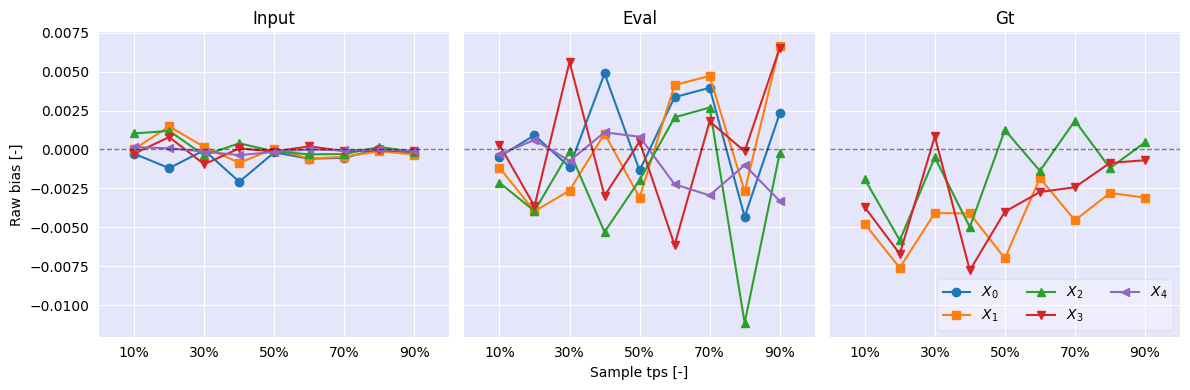

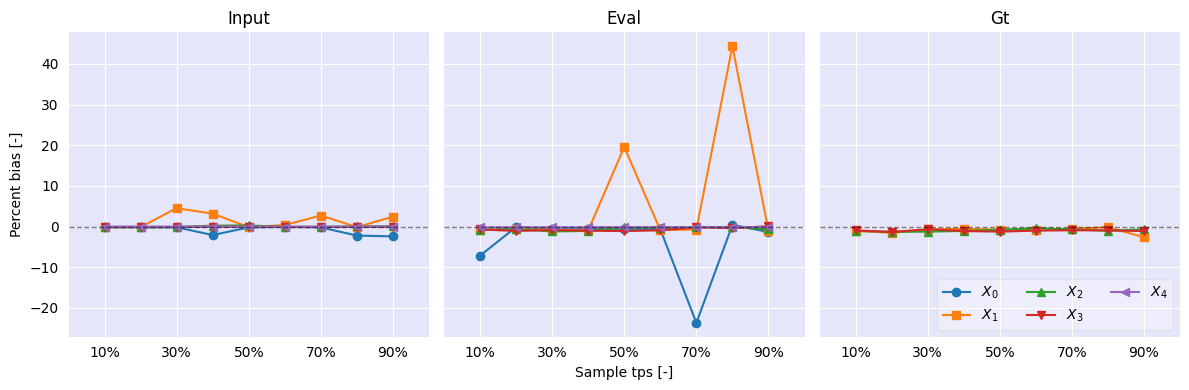

In [23]:
plot_bias_error(error_dict, percent_bias=False, save_dir=save_dir + 'MImodel_evaluation_bias_raw.pdf')
plot_bias_error(error_dict, percent_bias=True, save_dir=save_dir + 'MImodel_evaluation_bias_percent.pdf')

In [24]:
def plot_mae_mse_error(error_dict: "dict[str, dict]", metric: str, save_dir=None):
    markers = ['o', 's', '^', 'v', '<', '>', 'D', 'p', 'h', 'x', '+', '*']
    fig = plt.figure(figsize=(12,4))
    num_cases = len(error_dict[metric].keys())
    axs = fig.subplots(1, num_cases, sharex=True, sharey=True)
    for i, data_case in enumerate(error_dict[metric].keys()):
        ax = axs[i]
        sample_tps = list(error_dict[metric][data_case].keys())
        values = list(error_dict[metric][data_case].values())
        values = np.array(values)
        num_vars = values.shape[1]
        print(data_case, values.shape)
        if (num_vars < 8):
            # for few variables we plot each var
            for var_i in range(num_vars):
                ax.plot(sample_tps, values[:, var_i], marker=markers[var_i], ms=4, label=f'$X_{var_i}$', c=f'C{var_i}')
        else:
            # for many variables we use boxplot
            widths = 0.015
            values = [v[~np.isnan(v)] for v in values]
            positions = sample_tps
            bp = ax.boxplot(values, positions=positions, widths=widths, patch_artist=True)
            
        ax.set_title(data_case.capitalize())
    
    # ticks
    labels = [f'{tp:.0%}' for tp in sample_tps]
    ax.set_xticks(sample_tps[::2], labels=labels[::2])
    # ax.set_xticks(sample_tps, minor=True)
    axs[0].set(ylabel=f'{metric.upper()} [-]') 
    axs[1].set(xlabel='Sample tps [-]')
    
    # set background color and grid
    for ax in axs:
        ax.set_facecolor('lavender')
        # ax.set_facecolor('#b3b3b3')
        # ax.set_facecolor('black')
        ax.set(xlim=(0,1), ylim=(0,None))
        ax.spines[:].set_visible(False)
        ax.grid(visible=True, color='#b3b3b3')
        ax.grid(visible=True, color='white')
        ax.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=True)
    
    # axs[0].spines['left'].set_visible(True)
    axs[0].tick_params(labelleft=True)
    ax.legend(ncols=3, loc='lower right', framealpha=0.3)
    plt.tight_layout()
    if save_dir is not None:
        fig.savefig(save_dir, bbox_inches='tight')

input (9, 5)
eval (9, 5)
gt (9, 5)
input (9, 5)
eval (9, 5)
gt (9, 5)


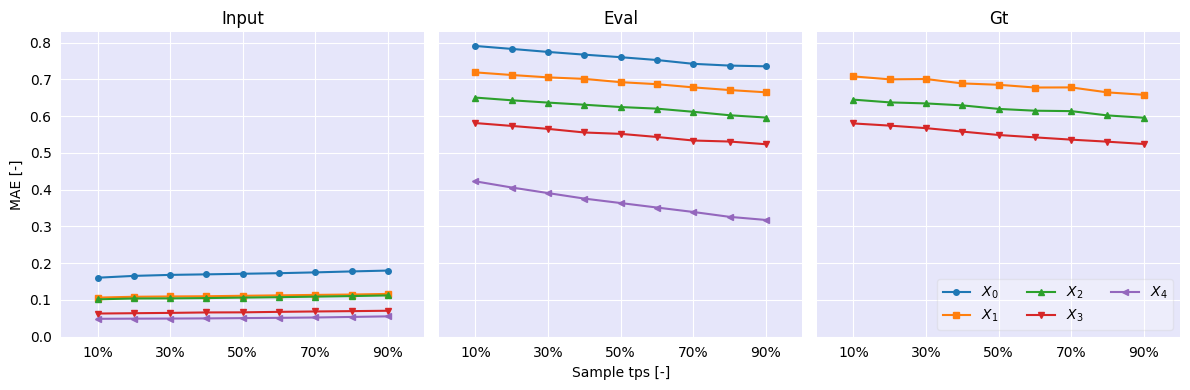

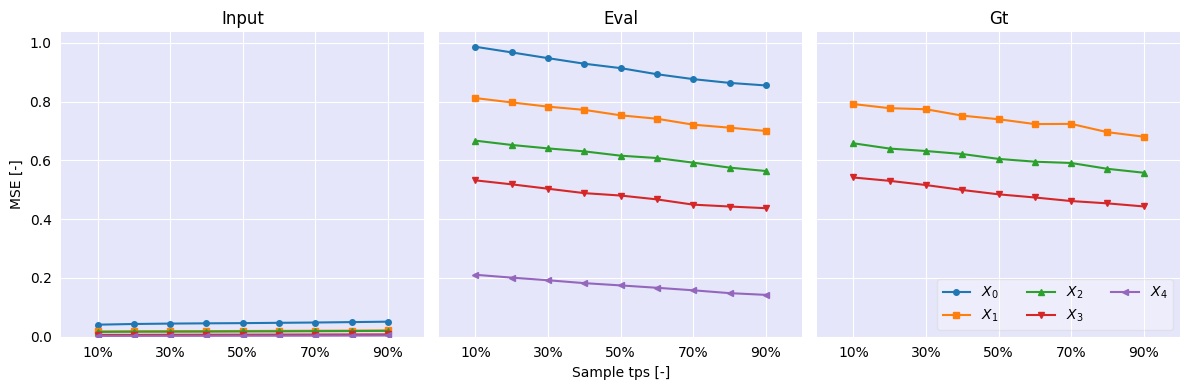

In [30]:
plot_mae_mse_error(error_dict, metric='mae', save_dir=save_dir + 'MImodel_evaluation_mae.pdf')
plot_mae_mse_error(error_dict, metric='mse', save_dir=save_dir + 'MImodel_evaluation_mse.pdf')

In [33]:
from typing import Literal

def plot_cov_widths(error_dict: "dict[str, dict]", metric: Literal['coverage_ratio', 'average_width'], save_dir=None):
    # error_dict[metric][data_case][sample_tps][quantiles][var_i]
    metric_print = metric.capitalize().replace("_"," ")
    markers = ['o', 's', '^', 'v', '<', '>', 'D', 'p', 'h', 'x', '+', '*']
    num_cases = len(error_dict[metric].keys())
    data_cases = list(error_dict[metric].keys())
    for sample_tp in error_dict[metric][data_cases[0]].keys():
        # create figure for every sample_tp
        fig = plt.figure(figsize=(12,4))
        axs = fig.subplots(1, num_cases, sharex=True, sharey=True)
        titles = {'input': f'Input ({sample_tp:.0%})',
                  'eval': f'Eval ({1-sample_tp:.0%})',
                  'gt': 'Gt'}
        for i, data_case in enumerate(data_cases):
            ax = axs[i]
            quantiles = list(error_dict[metric][data_case][sample_tp].keys())
            values = list(error_dict[metric][data_case][sample_tp].values())
            values = np.array(values)
            num_vars = values.shape[1]
            for var_i in range(num_vars):
                ax.plot(quantiles, values[:, var_i], marker=markers[var_i], ms=4, label=f'$X_{var_i}$', c=f'C{var_i}')
            if metric == 'coverage_ratio':
                ax.plot([0,1], [0,1], ls='--', color='black', alpha=0.5)
            ax.set_title(titles.get(data_case, data_case.capitalize()))
            
                
        # ticks
        labels = [f'{tp:.0%}' for tp in quantiles]
        axs[0].set_xticks(quantiles[::2], labels=labels[::2])
        if metric == 'coverage_ratio':
            ticks = np.arange(0, 1.1, 0.1)
            labels = [f'{i:.0%}' for i in ticks]
            axs[0].set_yticks(ticks[::2], labels=labels[::2])
            
        # ax.set_xticks(sample_tps, minor=True)
        axs[0].set(ylabel=f'{metric_print} [-]') 
        axs[1].set(xlabel='Inner quantile [-]')
        
        # set background color and grid
        for ax in axs:
            ax.set_facecolor('lavender')
            ax.set(xlim=(0,1), ylim=(0,None))
            ax.spines[:].set_visible(False)
            ax.grid(visible=True, color='#b3b3b3')
            ax.grid(visible=True, color='white')
            ax.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=True)
            
        axs[0].tick_params(labelleft=True)
        axs[-1].legend(ncols=3, loc='lower right', framealpha=0.3)
                
        plt.tight_layout()
        if save_dir is not None:
            path = save_dir[:-3] + f'_{metric}_sample_tp_{sample_tp:.2f}_' + save_dir[-3:]
            fig.savefig(path, bbox_inches='tight')

ValueError: Format '10_pdf' is not supported (supported formats: eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff, webp)

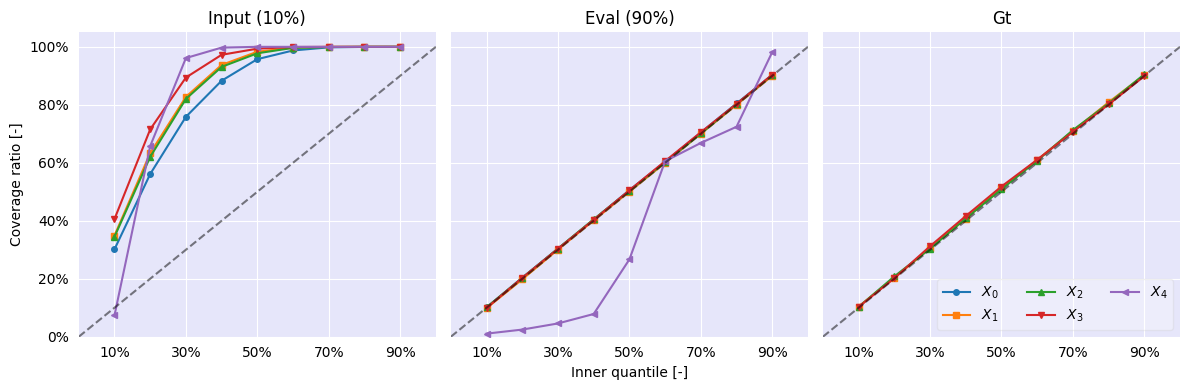

In [34]:
plot_cov_widths(error_dict, metric='coverage_ratio', save_dir=save_dir + 'MImodel_evaluation.pdf')
plot_cov_widths(error_dict, metric='average_width', save_dir=save_dir + 'MImodel_evaluation.pdf')